# Solve the moments

## Prepare

In [1]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt
import sys

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Sech = lambda x: 1/np.cosh(x)
ArcSin = np.arcsin
ArcTanh = np.arctanh
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)


def Plot(fun, xminmax, n=100,xfun=np.linspace, xlog=False, ylog=False):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

from helperFunctions import derivative, alpha_p, cs_sq, dYdtau, dvTdxi, r_func, μ, w

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size='20')
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')

In [2]:
#current_dir = os.path.dirname(os.path.abspath(__file__))
#model_directory = os.path.join(current_dir, '..', 'cosmotransition_z2sb', 'cosmoTransitions')
model_directory='/Users/quarkquartet/Work/Wall-velocity/model/'
sys.path.append(model_directory)
import baseMo_s_b_d as bm

### Load a benchmark

In [3]:
m = bm.model(702.654702269, -102.146250858, 0.112009439661, 0.0037322807528, -0.0370639674565,10000)
m.findAllTransitions()
hv = m.TnTrans[0]['high_vev']
lv = m.TnTrans[0]['low_vev']
Tnuc = m.TnTrans[0]['Tnuc']
Vtot = m.Vtot

Tracing phase starting at x = [246.00000051 572.58176356] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................................
Tracing phase starting at x = [-2.27347289e-07  1.79312356e+02] ; t = 68.27354525855334
Tracing minimum down
traceMinimum t0 = 68.2735
..............................................................................
Tracing minimum up
traceMinimum t0 = 68.2735
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [4]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

def find_Tsh(Tm, vw):
    guess_sol = optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[0.1,Tnuc])
    try:
        vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max*0.9999)
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)
    return T_prof(xsh)

In [5]:
Tmax = m.TnTrans[0]['Tnuc']
Tmin = 55
vw = 0.5
for i in range(30):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal, vw)
    if Tsh < m.TnTrans[0]['Tnuc']:
        Tmin = Tcal
    else:
        Tmax = Tcal
Tm = Tcal
vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tcal, hv, lv),[0.3, Tnuc], xtol=1e-10)

In [6]:
Tm

59.96295744338835

In [58]:
hv_new = m.findMinimum(hv, Tp)
lv_new = m.findMinimum(lv, Tm)

## Load field value profile

In [97]:
h0 = lv_new[0]
s0 = lv_new[1]-hv_new[1]
s_initial=hv_new[1]
def h_profile(z,Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz

def s_profile(z, Ls, deltas):
    z = np.asanyarray(z)
    sz = 0.5*s0*(1-np.tanh(z/Ls + deltas)) + s_initial
    return sz

c1 = w(Vtot, Tm, lv_new) * vw/(1-vw**2)
s1=c1
c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vw**2 /(1-vw**2)
s2=c2

def T33(T,z, Lh, Ls, deltas):
    derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
    ders = derivative(lambda zvalue: s_profile(zvalue,Ls,deltas),z)
    field_value = [h_profile(z, Lh), s_profile(z, Ls, deltas)]
    return (0.5*(derh**2 + ders**2) - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

## Calculate moments

In [116]:
def moments(Lh, Ls, deltas):
    npoints = 100
    z_range = np.linspace(-8*max(Lh,Ls), 5*max(Lh,Ls), npoints)
    T_sol = np.zeros((npoints,))
    for i in range(npoints):
        T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), 55, method='Nelder-Mead', bounds=[(40,90)])
        if T33min.fun > 0:
            T_sol[i]=T33min.x[0]
        else:
            try:
                s = optimize.newton(lambda T: T33(T, z_range[i], Lh, Ls, deltas), Tnuc)
            except:
                s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), Tnuc)[0]
            T_sol[i] = s

    hvalues = h_profile(z_range, Lh)
    svalues = s_profile(z_range, Ls, deltas)
    fields = np.array([hvalues, svalues]).T
    dV = m.gradV(fields, T_sol)
    Eh = dV[:,0]
    Es = dV[:,1]
    hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
    sprime = np.vectorize(lambda z: -0.5*(s0*Sech(deltas + z/Ls)**2)/Ls)
    Ph = np.trapz(- Eh * hprime(z_range), z_range)
    Gh = np.trapz(- Eh * hprime(z_range) * np.tanh(z_range/Lh), z_range)
    Ps = np.trapz(- Es * sprime(z_range), z_range)
    Gs = np.trapz(- Es * sprime(z_range) * np.tanh(z_range/Ls + deltas), z_range)
    return np.array([Ph, Ps, Gh, Gs])/1e6

In [113]:
moments(0.01,0.01,0.3)

array([-4.79782675, -1.68900462, -0.26809109,  1.19641518])

In [114]:
def force_diff(Lh, Ls, deltas):
    Ph, Ps, Gh, Gs = moments(Lh, Ls, deltas)
    return Ph-Ps

$\delta s$ should be determined by $P_h - P_s$. By physical meaning, this should be a monotomic function of $\delta s$.

### Solve $\delta s$, then $L_s$, then $L_h$.

In [30]:
def solve_deltas(Lh, Ls):
    try:
        dsol = optimize.newton(lambda d: force_diff(Lh, Ls, d), 0.1)
    except:
        try:
            dsol = optimize.newton(lambda d: force_diff(Lh, Ls, d), -0.1)
        except:
            try:
                dsol = optimize.brentq(lambda d: force_diff(Lh, Ls, d), -5,5)
            except:
                dsol = optimize.brentq(lambda d: force_diff(Lh, Ls, d), -20,20)
    return dsol

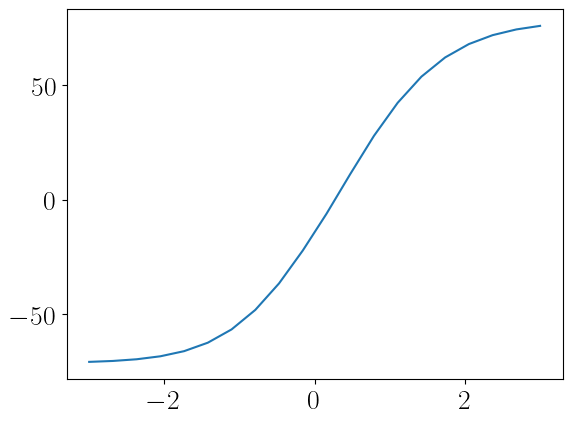

In [17]:
Plot(lambda d: force_diff(0.1,0.1, d), (-3,3), n=20)

Now let's see how $G_s$ depends on $L_s$ for solved $\delta s$.

In [117]:
solve_deltas(1.0, 0.8)

0.36686522131906435

In [36]:
Gsrange = np.ones((5,20))
Lhrange = [0.1,0.5,1.0,1.5, 2.0]
ratiorange = np.logspace(-2,2,20)
for i in range(5):
    Lh = Lhrange[i]
    Gslist = np.copy(Gsrange[i])
    for j in range(20):
        Ls = ratiorange[j] * Lh
        deltas = solve_deltas(Lh, Ls)
        Gslist[j] = moments(Lh, Ls, deltas)[-1]
    Gsrange[i] = Gslist

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_7806/68677936.py:18: RuntimeWarning: overflow encountered in cosh
  Sech = lambda x: 1/np.cosh(x)


Text(0.5, 1.0, '$\\delta s$ solved by $P_h = P_s$.')

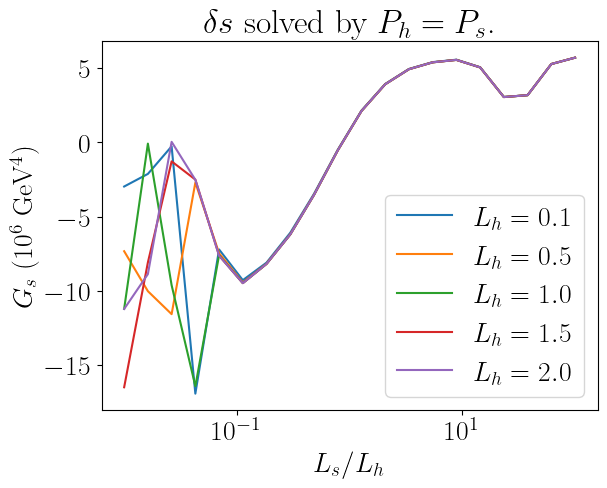

In [39]:
for i in range(5):
    plt.plot(ratiorange, Gsrange[i], label=f'$L_h = {Lhrange[i]}$')
plt.xscale('log')
plt.xlabel(r'$L_s/L_h$')
plt.ylabel(r'$G_s$ ($10^6$ GeV$^4$)')
plt.legend()
plt.title(r'$\delta s$ solved by $P_h = P_s$.')

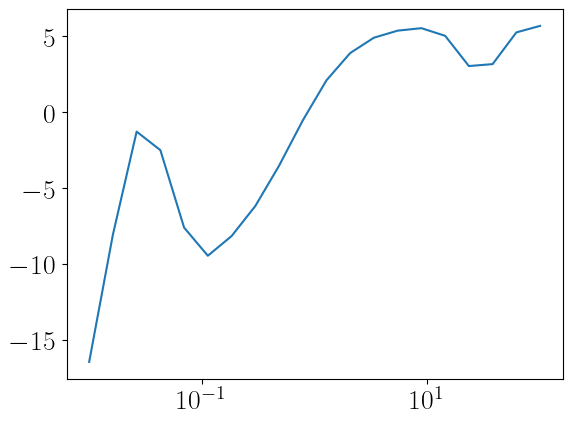

In [46]:
plt.plot(ratiorange, Gsrange[3])
plt.xscale('log')

In [29]:
moments(1, 3, solve_deltas(1,3))[2]

-5.223462983529182

In [118]:
Lhrange = np.logspace(-2,1,20)
Ghrange = np.ones((20,))*100
for i in range(20):
    Lh = Lhrange[i]
    print("Computing for Lh = " + str(Lh))
    lsmin = Lh/10
    lsmax = Lh*10
    Lsrange = np.logspace(Log10(lsmin), Log10(lsmax), 20)
    Gslist = np.array([moments(Lh, Ls, solve_deltas(Lh, Ls))[-1] for Ls in Lsrange])
    # Then solve for Ls
    # If Gs = 0 reached, compute Gh for this Lh and Ls.
    # If not, discard this, return 100.
    if Gslist.min() * Gslist.max() < 0:
        Gsfunc = interpolate.interp1d(Lsrange, Gslist)
        Lssol = optimize.brentq(Gsfunc, Lsrange[0], Lsrange[-1])
        Ghrange[i] = moments(Lh, Lssol, solve_deltas(Lh, Lssol))[2]
        print("Find Ls = " + str(Lssol))
        print("Gh = " + str(Ghrange[i]))
    else:
        print("No proper Ls found.")
        continue


Computing for Lh = 0.01
Find Ls = 0.008195271963456922
Gh = 0.26136582463016816
Computing for Lh = 0.01438449888287663
Find Ls = 0.011804400671933418
Gh = 0.38094577170831045
Computing for Lh = 0.0206913808111479
Find Ls = 0.017024206181893757
Gh = 0.5328421211170087
Computing for Lh = 0.029763514416313176
Find Ls = 0.024595915146787307
Gh = 0.8050199560463545
Computing for Lh = 0.04281332398719394
Find Ls = 0.03565148516062021
Gh = 1.0733704140882445
Computing for Lh = 0.06158482110660264
Find Ls = 0.05203215526980671
Gh = 1.0833578391097622
Computing for Lh = 0.08858667904100823
Find Ls = 0.07581835148952777
Gh = 0.7121778867068689
Computing for Lh = 0.12742749857031335
Find Ls = 0.1095575810464912
Gh = 0.6264736422983921
Computing for Lh = 0.18329807108324356
Find Ls = 0.15791121936883395
Gh = 0.5916643400252106
Computing for Lh = 0.26366508987303583
Find Ls = 0.2273617525051006
Gh = 0.5759733351944029
Computing for Lh = 0.37926901907322497
Find Ls = 0.3271954875119896
Gh = 0.568623

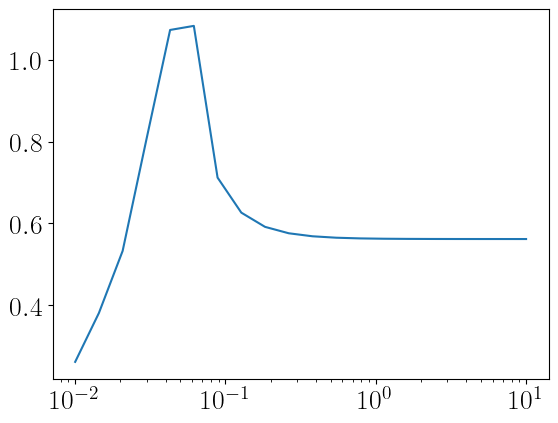

In [119]:
plt.plot(Lhrange, Ghrange)
plt.xscale('log')

In [27]:
solve_Ls(0.01)

0.00811519040076434

In [28]:
Gh_min(0.01)

0.4620006012776589

In [122]:
Gh_min(0.0001)

0.18971121815094702

In [120]:
def solve_Ls(Lh):
    """Solve Ls from Gs = 0 for a certain Lh.
    δs is always fixed to solve Ph-Ps = 0."""
    lsmin = Lh/10
    lsmax = Lh*10
    try:
        Lssol = optimize.newton(lambda Ls: moments(Lh, Ls, solve_deltas(Lh, Ls))[-1], Lh)
    except:
        Lssol = optimize.brentq(lambda Ls: moments(Lh, Ls, solve_deltas(Lh, Ls))[-1], lsmin, lsmax)
    return Lssol
    

In [12]:
Lssol = solve_Ls(1.0)
print(Lssol)

0.8591396550657807


Then the remaining is $L_h$. The condition is to vanish $G_h$.

In [121]:
def Gh_min(Lh):
    """Gh as a function of Lh, with Ls and deltas solved."""
    Lssol = solve_Ls(Lh)
    dssol = solve_deltas(Lh, Lssol)
    return moments(Lh, Lssol, dssol)[2]

In [31]:
def Ptot(Lh):
    Lssol = solve_Ls(Lh)
    dssol = solve_deltas(Lh, Lssol)
    Ph, Ps, Gh, Gs = moments(Lh, Lssol, dssol)
    return Ph + Ps

In [32]:
Ptot(0.001)

-6.380020883939934

In [33]:
Ptot(0.0001)

-6.382126274066213

In [34]:
Ptot(10)

-1.0980825090025057

In [59]:
Gh_min(1.0)

0.6980236778542181

In [14]:
lhrange = np.linspace(0.5,1.5,20)
Ghrange = np.zeros((20,))

In [15]:
for i in range(20):
    Ghrange[i] = Gh_min(lhrange[i])

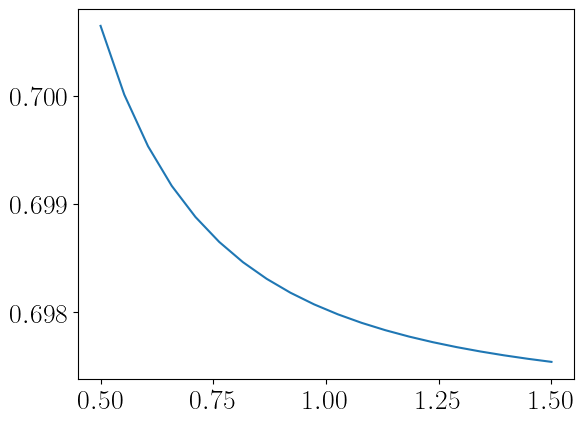

In [16]:
plt.plot(lhrange, Ghrange)

In [17]:
Gh_min(3)

0.6972506630832954

Now we are having a problem. It seems that the solution for moments does not exist. Once 2 of the solutions are satisfied there is no solution for the 3rd. Fine. Maybe we should search for a global minimization for it.

### Solve $L_h$ and $L_s$ at first then $\delta s$

In [11]:
def solve_Ls(Lh, deltas):
    try:
        dsol = optimize.newton(lambda Ls: moments(Lh, Ls, deltas)[-1],Lh)
    except:
        dsol = optimize.brentq(lambda Ls: moments(Lh, Ls, deltas)[-1], 0.1*Lh, 10*Lh)
    return dsol

In [12]:
solve_Ls(0.01, 0.3)

0.008768146634913742

In [13]:
Lhrange = np.logspace(-3,1,20)
Ghrange = np.zeros((20,))
for i in range(20):
    Lh = Lhrange[i]
    Ls = solve_Ls(Lh, 0.3)
    Ghrange[i] = moments(Lh, Ls, 0.3)[2]


Text(0, 0.5, '$G_h$')

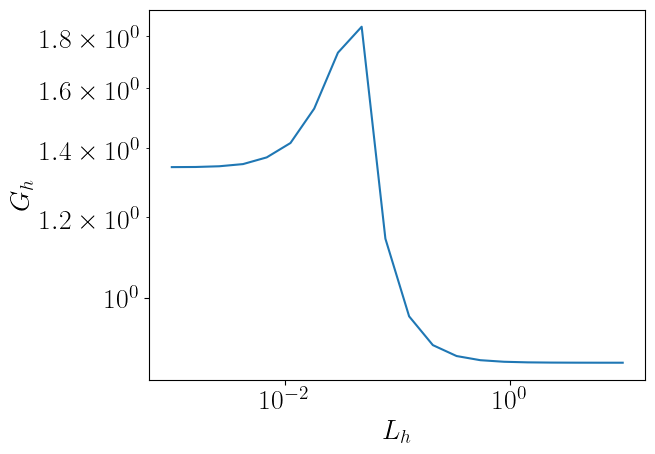

In [14]:
plt.plot(Lhrange, Ghrange)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_h$')
plt.ylabel(r'$G_h$')

OK it seems $G_h$ and $G_s$ cannot vanish simultaneously.

### Solve $L_h$ then $L_s$

In [10]:
def solve_Lh(Ls, deltas):
    try:
        sol = optimize.newton(lambda Lh: moments(Lh, Ls, deltas)[2], Ls)
    except:
        sol = optimize.brentq(lambda Lh: moments(Lh, Ls, deltas)[2], 0.1*Ls,10*Ls)
    return sol

In [ ]:
def solve_Ls(Lh, deltas):
    try:
        dsol = optimize.newton(lambda Ls: moments(Lh, Ls, deltas)[-1],Lh)
    except:
        dsol = optimize.brentq(lambda Ls: moments(Lh, Ls, deltas)[-1], 0.1*Lh, 10*Lh)
    return dsol